In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import warnings
from pandas.errors import SettingWithCopyWarning

# suppress pandas copy warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# 1. LOAD EXPANDED DATASET & FILTER YEARS
# ---------------------------------------------------
mr = (
    pd.read_csv("updated_QQQ_MarketRisk.csv", parse_dates=["Date"])
      .sort_values("Date")
      .query("Date.dt.year >= 2015 and Date.dt.year <= 2023")
      .reset_index(drop=True)
)

In [3]:
# 2. ENGINEER NEXT-DAY REALIZED VOLATILITY
# ---------------------------------------------------
mr["NextVol"] = mr["QQQ_Realized_Volatility"].shift(-1)

In [4]:
# 3. SELECT FEATURES & CLEAN
# ---------------------------------------------------
features = [
    "QQQ_Return",
    "QQQ_Realized_Volatility",
    "QQQ_Volume",
    "VIX",
    "RSI_14",
    "VXN",
    "FedRate",
]

# coerce numeric, drop any rows missing features or target
for col in features + ["NextVol"]:
    mr[col] = pd.to_numeric(mr[col], errors="coerce")

mr.dropna(subset=features + ["NextVol"], inplace=True)
mr.reset_index(drop=True, inplace=True)

# --- add the Year column here so we can use it later ---
mr["Year"] = mr["Date"].dt.year


In [5]:
# 4. ROLLING 3-YEAR WINDOW → PREDICT ONLY FOR 2020–2023
# ---------------------------------------------------
results = []
first_date = mr["Date"].min()

for _, row in mr.iterrows():
    today = row["Date"]
    year  = today.year

    # only record predictions in test window
    if year < 2020 or year > 2023:
        continue

    # require 3 full years of history
    if today < (first_date + pd.DateOffset(years=3)):
        continue

    # build train window [today - 3y, today)
    window_start = today - pd.DateOffset(years=3)
    train_df     = mr[(mr["Date"] >= window_start) & (mr["Date"] < today)]

    # skip if too few training rows
    if len(train_df) < 200:
        continue

    X_train = train_df[features]
    y_train = train_df["NextVol"]

    # today's features → one‐step forecast
    X_today = row[features].values.reshape(1, -1)
    y_true  = row["NextVol"]

    # train & predict
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=50,
        learning_rate=0.05,
        random_state=42,
    )
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_today)[0]

    results.append({
        "Date":             today,
        "PredictedNextVol": y_pred,
        "ActualNextVol":    y_true
    })

In [6]:
# 5. ASSEMBLE & SAVE
# ---------------------------------------------------
out_df = pd.DataFrame(results)
out_df.to_csv("rolling_3yr_preds_2020_23.csv", index=False)
print(f"Saved {len(out_df)} predictions → rolling_3yr_preds_2020_23.csv")

Saved 1005 predictions → rolling_3yr_preds_2020_23.csv


In [7]:
# 6. COMPUTE TEST METRICS (2020–2023)
# ---------------------------------------------------
y_pred = out_df["PredictedNextVol"]
y_true = out_df["ActualNextVol"]

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print("\n--- Test Metrics (2020–2023) ---")
print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test R²  : {r2:.4f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test MAPE: {mape:.2%}")


--- Test Metrics (2020–2023) ---
Test MSE : 0.000778
Test RMSE: 0.027893
Test R²  : 0.9521
Test MAE : 0.014613
Test MAPE: 5.91%


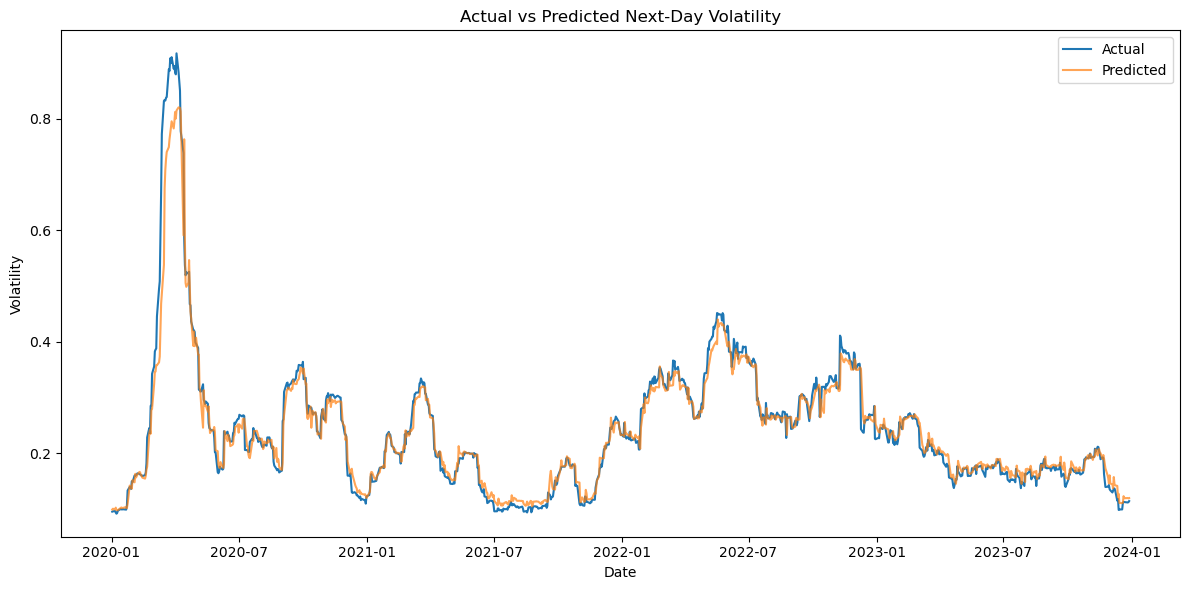

In [8]:
# 7. Time Series: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(out_df["Date"], out_df["ActualNextVol"], label="Actual")
plt.plot(out_df["Date"], out_df["PredictedNextVol"], label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Next-Day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

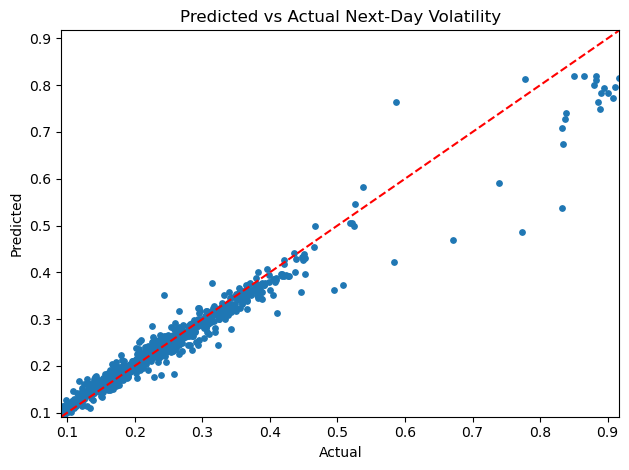

In [9]:
# 8. Scatter: Predicted vs Actual (fixed min/max calculation)
plt.figure()
plt.scatter(out_df["ActualNextVol"], out_df["PredictedNextVol"], s=15)

# compute global min/max
minv = min(out_df["ActualNextVol"].min(),
           out_df["PredictedNextVol"].min())
maxv = max(out_df["ActualNextVol"].max(),
           out_df["PredictedNextVol"].max())

# plot 45° line in red
plt.plot([minv, maxv], [minv, maxv], "r--")
plt.xlim(minv, maxv)
plt.ylim(minv, maxv)

plt.title("Predicted vs Actual Next-Day Volatility")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

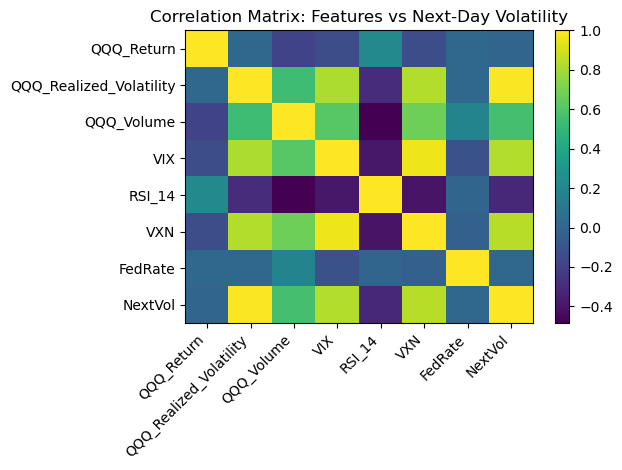

In [10]:
# ——— 2. Correlation Heatmap ———
corr = mr[features + ["NextVol"]].corr()
plt.figure()
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix: Features vs Next-Day Volatility")
plt.tight_layout()
plt.show()

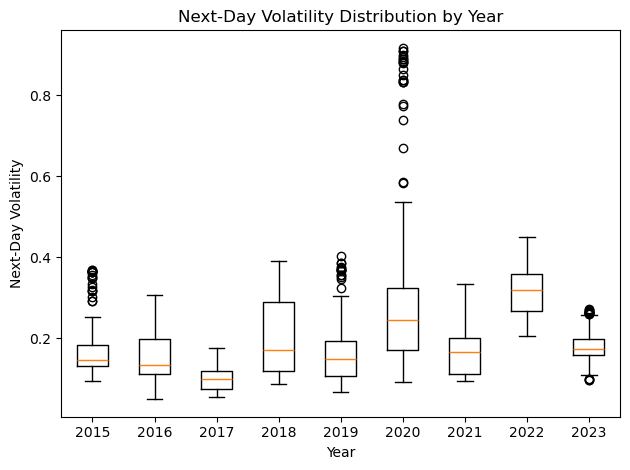

In [11]:
# ——— 3. Volatility Distribution by Year (Boxplots) ———
years = sorted(mr["Year"].unique())           # now works because we set mr["Year"]
data  = [mr[mr.Year == y]["NextVol"].values for y in years]

plt.figure()
plt.boxplot(data)
plt.xticks(range(1, len(years)+1), years)
plt.title("Next-Day Volatility Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Next-Day Volatility")
plt.tight_layout()
plt.show()

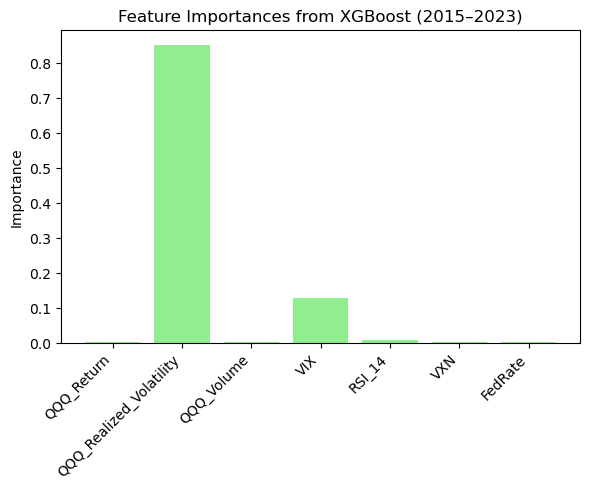

In [12]:
# ——— 4. Feature Importance (Full-Sample XGBoost) ———
X_full = mr[features]
y_full = mr["NextVol"]
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=50,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_full, y_full, verbose=False)

importances = model.feature_importances_
plt.figure(figsize=(6,5))
plt.bar(range(len(features)), importances, color="lightgreen")   # <— set your color here
plt.xticks(range(len(features)), features, rotation=45, ha="right")
plt.title("Feature Importances from XGBoost (2015–2023)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


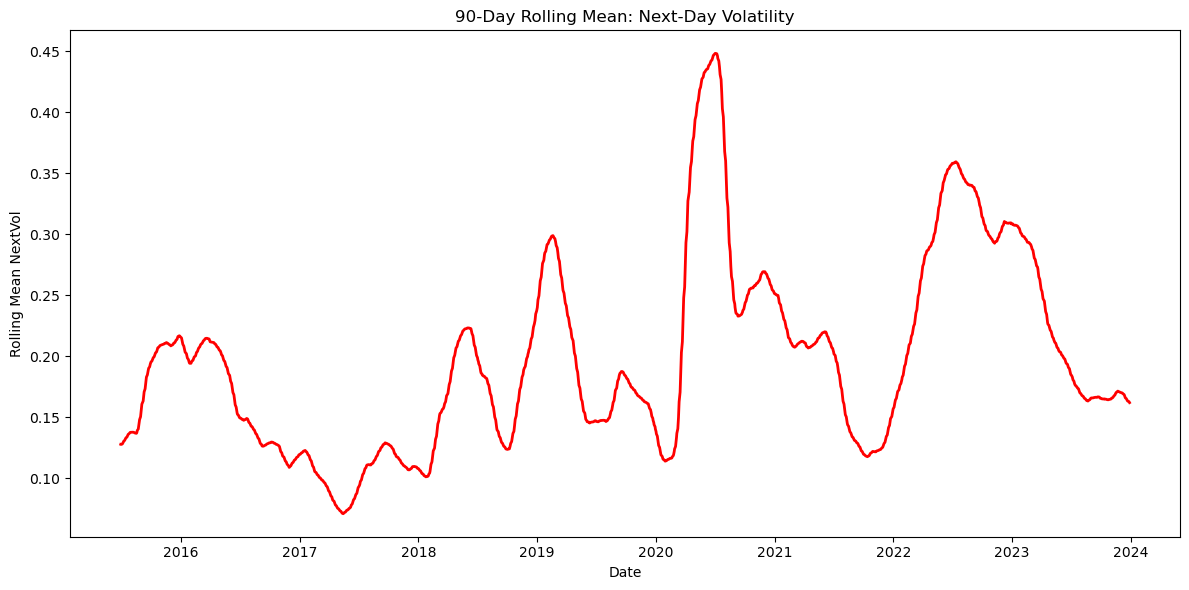

In [13]:
# ——— 5. 90-Day Rolling Mean of Next-Day Volatility ———
mr = mr.sort_values("Date")
mr["Rolling90"] = mr["NextVol"].rolling(window=90).mean()

plt.figure(figsize=(12, 6))
plt.plot(
    mr["Date"],
    mr["Rolling90"],
    color="red",    # ← change this to any Matplotlib color name or hex
    linewidth=2
)
plt.title("90-Day Rolling Mean: Next-Day Volatility")
plt.xlabel("Date")
plt.ylabel("Rolling Mean NextVol")
plt.tight_layout()
plt.show()
